# Genome PCA Laboratory
This notebook builds **dense movie embeddings** from the MovieLens **Genome** (tag relevance) features using **PCA**.

**Goal:** compress the ~1,100 tag relevance dimensions into a smaller set (e.g., 50–200) that can be used as movie features in downstream models.

**Cronological considerations**: This dataset was created orignally in 2011 and since then have had several updates. The seminal paper for this dataset is in [here](https://files.grouplens.org/datasets/movielens/tag-genome/README.html).


### Concept:

Users tagged movies on MovieLens with free-form tags (e.g., “dark,” “funny,” “violent”).

These raw tags were cleaned, merged, and normalized into a controlled vocabulary of ~1,100 canonical tags.

Because many movies had few or no user-submitted tags, researchers applied matrix factorization models (similar to collaborative filtering) to infer missing tag–movie relevance scores.

The result is a dense matrix where every movie has a relevance score for every tag, representing how strongly that tag describes the film.

## 0) Imports
We keep imports at the top for reproducibility.

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

## 1) Load Genome data

Only `genome_scores` is required for PCA; `genome_tags` is useful for inspection.

In [4]:
DATA_DIR = Path("../data/raw/movielens-20m-dataset/") 
paths = { "genome_tags": DATA_DIR / "genome_tags.csv",
          "genome_scores": DATA_DIR / "genome_scores.csv",
}

In [5]:
g_tags_dtypes = {"tagId": "int32", "tag": "string"}
g_scores_dtypes = {"movieId": "int32", "tagId": "int32", "relevance": "float32"}

In [9]:
genome_tags = pd.read_csv(paths["genome_tags"], dtype=g_tags_dtypes)
genome_scores = pd.read_csv(paths["genome_scores"], dtype=g_scores_dtypes)

print("genome_scores:", genome_scores.shape)
print("genome_tags:", genome_tags.shape)
genome_scores.head()

genome_scores: (11709768, 3)
genome_tags: (1128, 2)


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


## 2) Sanity checks
We verify basic integrity:
- relevance range
- number of movies/tags
- missing values


In [10]:
print("relevance min/max:", genome_scores["relevance"].min(), genome_scores["relevance"].max())
print("n movies:", genome_scores["movieId"].nunique())
print("n tags:", genome_scores["tagId"].nunique())
print("missing relevance:", genome_scores["relevance"].isna().sum())


relevance min/max: 0.00025 1.0
n movies: 10381
n tags: 1128
missing relevance: 0


## 3) Pivot to a movie × tag matrix
PCA expects a matrix. We pivot to shape:
- rows: movies
- columns: tagId
- values: relevance

Missing combinations (should be rare in Genome) are filled with 0.


In [11]:
genome_mat = (
    genome_scores.pivot(index="movieId", columns="tagId", values="relevance")
    .fillna(0.0)
)

print("Genome matrix shape:", genome_mat.shape)
genome_mat.iloc[:3, :5]


Genome matrix shape: (10381, 1128)


tagId,1,2,3,4,5
movieId,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675
2,0.03975,0.04375,0.03775,0.04800,0.11025
3,0.04350,0.05475,0.02800,0.07700,0.05400


## 4) Scaling choice
Genome relevance values are already bounded in [0, 1].

- **Option A (default):** run PCA directly on relevance values.
- **Option B:** standardize columns (tags) before PCA.

In practice, both can work. We'll implement **Option A** first (simpler, common for bounded features), and keep **Option B** as an optional toggle.


In [12]:
USE_STANDARD_SCALER = False  # set True to standardize tag columns before PCA

X = genome_mat.values
if USE_STANDARD_SCALER:
    scaler = StandardScaler(with_mean=True, with_std=True)
    X = scaler.fit_transform(X)

print("X dtype:", X.dtype, "X shape:", X.shape)


X dtype: float32 X shape: (10381, 1128)


## 5) Fit PCA and pick number of components
We fit PCA and inspect explained variance to select a reasonable dimensionality (e.g., 50–200).
The general idea is to fit PCA with enough components to inspect explained variance.

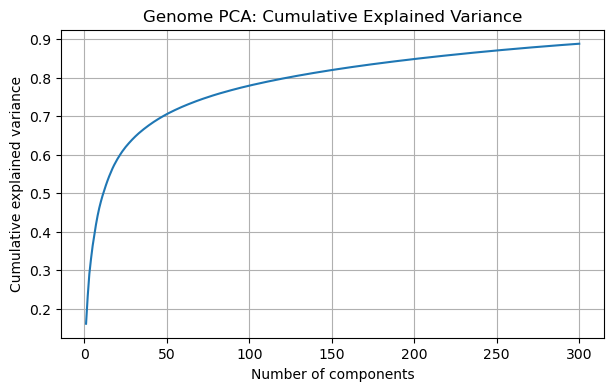

k= 10 -> cum explained variance=0.4784
k= 25 -> cum explained variance=0.6201
k= 50 -> cum explained variance=0.7055
k= 75 -> cum explained variance=0.7499
k=100 -> cum explained variance=0.7795
k=150 -> cum explained variance=0.8200
k=200 -> cum explained variance=0.8486
k=300 -> cum explained variance=0.8883


In [13]:
pca_probe = PCA(n_components=300, random_state=42)
pca_probe.fit(X)

explained = pca_probe.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum_explained) + 1), cum_explained)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Genome PCA: Cumulative Explained Variance")
plt.grid(True)
plt.show()

for k in [10, 25, 50, 75, 100, 150, 200, 300]:
    print(f"k={k:3d} -> cum explained variance={cum_explained[k-1]:.4f}")


## 6) Build final PCA embeddings
Choose `N_COMPONENTS` based on the plot (typical choices: 50, 100, 150).
We output a dataframe keyed by `movieId`, ready to merge into ratings.


In [14]:
N_COMPONENTS = 50  # adjust after inspecting explained variance

pca = PCA(n_components=N_COMPONENTS, random_state=42)
Z = pca.fit_transform(X)

genome_pca = pd.DataFrame(
    Z,
    index=genome_mat.index,
    columns=[f"gen_pca_{i}" for i in range(N_COMPONENTS)]
).reset_index()

print("genome_pca:", genome_pca.shape)
genome_pca.head()


genome_pca: (10381, 51)


,movieId,gen_pca_0,gen_pca_1,gen_pca_2,gen_pca_3,gen_pca_4,gen_pca_5,gen_pca_6,gen_pca_7,gen_pca_8,...,gen_pca_40,gen_pca_41,gen_pca_42,gen_pca_43,gen_pca_44,gen_pca_45,gen_pca_46,gen_pca_47,gen_pca_48,gen_pca_49
0,1,0.636798,2.121483,-2.282146,1.081998,1.294144,-1.081911,1.067077,1.318038,0.792412,...,0.152204,0.135698,-0.352174,0.079192,0.083382,-0.029983,0.004625,-0.178799,-0.048288,0.256628
1,2,-1.620004,1.542517,-1.146535,0.830372,0.070496,-0.456103,0.088794,1.050021,0.451454,...,-0.140928,-0.248063,-0.093102,-0.170851,-0.007845,-0.259730,0.294296,0.322813,-0.240406,0.017080
2,3,-1.412227,-0.121371,-0.609702,-0.260178,0.122943,-0.170473,0.299639,-0.007988,-0.029892,...,-0.016399,-0.197612,0.019481,-0.177835,0.095876,0.133215,0.092038,0.011126,-0.267446,-0.078150
3,4,-1.332493,-0.876134,-1.005760,-0.371487,-0.163382,0.678833,0.035171,0.424432,0.400780,...,-0.080414,-0.070245,-0.060324,-0.103020,0.047513,0.118565,-0.013440,-0.092674,0.028619,-0.084775
4,5,-1.727381,-0.058476,-1.328709,-0.058479,0.361463,0.164155,0.477843,0.437563,0.076511,...,0.173518,-0.122367,0.134050,-0.126825,-0.005090,0.007944,0.066814,-0.181082,-0.239570,-0.077210


## 7) Persist embeddings
We save the PCA embeddings for reuse in other notebooks (fast reload).


In [15]:
out_path = f"../data/processed/genome_pca_{N_COMPONENTS}.parquet"
genome_pca.to_parquet(out_path, index=False)
print("Saved:", out_path)


Saved: ../data/processed/genome_pca_50.parquet


## 8) Optional: Inspect PCA components (tag loadings)
This helps interpret what each component captures semantically.
We list the strongest positive/negative loading tags for a selected component.


In [18]:
COMPONENT_ID = 5  

loadings = pca.components_[COMPONENT_ID]
tag_map = genome_tags.set_index("tagId")["tag"].to_dict()
tag_ids = genome_mat.columns.to_numpy()

top_pos_idx = np.argsort(loadings)[-15:][::-1]
top_neg_idx = np.argsort(loadings)[:15]

print("Top + loadings (tagId, tag, loading):")
for i in top_pos_idx:
    tid = int(tag_ids[i])
    print(tid, tag_map.get(tid, None), float(loadings[i]))

print("\nTop - loadings (tagId, tag, loading):")
for i in top_neg_idx:
    tid = int(tag_ids[i])
    print(tid, tag_map.get(tid, None), float(loadings[i]))


Top + loadings (tagId, tag, loading):
846 relationships 0.1622866690158844
787 plot 0.10385989397764206
540 independent film 0.09729105234146118
348 emotional 0.0937662124633789
913 shallow 0.0899110659956932
610 loneliness 0.08976948261260986
99 bad ending 0.08942703902721405
490 happy ending 0.08871419727802277
865 romantic comedy 0.08774034678936005
614 love story 0.08745276927947998
602 life philosophy 0.08630533516407013
297 depression 0.08595872670412064
777 pg-13 0.08523979038000107
299 destiny 0.08321181684732437
807 predictable 0.0828871876001358

Top - loadings (tagId, tag, loading):
215 classic -0.15647125244140625
140 black and white -0.10423000156879425
270 criterion -0.09057149291038513
481 gunfight -0.08487524837255478
634 masterpiece -0.08226852864027023
529 humorous -0.07554802298545837
536 imdb top 250 -0.07284637540578842
401 forceful -0.07151239365339279
918 silent -0.07070110738277435
508 historical -0.07004182785749435
455 goofy -0.06906624883413315
1098 wartime -

## 9) Optional: Merge PCA embeddings into ratings
If you already have `ratings` loaded, you can merge movie embeddings by `movieId`.
This step is safe with time splits because embeddings are static per movie.


In [ ]:
# Example (uncomment if ratings is available in this notebook):
# ratings = pd.read_parquet("train_prepared.parquet")  # or read ratings directly
# ratings = ratings.merge(genome_pca, on="movieId", how="left")
# ratings[["movieId"] + [c for c in genome_pca.columns if c.startswith("gen_pca_")]].head()


## 10) Final Observations

We selected **50 PCA components** because:

- They capture **~70% of the semantic variance** in the Tag Genome.
- They represent the **elbow point**, balancing information captured vs. additional noise and diminishing returns.
- They significantly **reduce redundancy and collinearity** present in the original ~1,100 tag dimensions.
- They **improve efficiency and stability** for tabular models such as XGBoost.
- They help **prevent overfitting** and maintain robustness in **time-based evaluation** scenarios.
- They follow **empirical best practices** in content-based recommender systems, where 32–64 dimensions are typically optimal.


## 11) Quick TEST

We Check if by only adding this features the XGBoost improves.

In [19]:
train = pd.read_parquet("../data/processed/train_prepared.parquet")
val   = pd.read_parquet("../data/processed/val_prepared.parquet")
test  = pd.read_parquet("../data/processed/test_prepared.parquet")

In [20]:
train = train.merge(genome_pca, on="movieId", how="left")
val = val.merge(genome_pca, on="movieId", how="left")
test = test.merge(genome_pca, on="movieId", how="left")

In [21]:
metadata = ['userId', 'movieId', 'rating', 'timestamp', 'timestamp_dt', 'high_rating']

In [22]:
feature_cols = [f for f in train.columns if f not in metadata]

target_col = "high_rating"

X_train, y_train = train[feature_cols], train[target_col]
X_val,   y_val   = val[feature_cols],   val[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("Positive rate (train/val/test):",
      y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))


X_train: (4490259, 77) y_train: (4490259,)
Positive rate (train/val/test): 0.4853 0.5269 0.5017


In [23]:
X_train = X_train.astype("float32").fillna(np.nan)
X_val   = X_val.astype("float32").fillna(np.nan)
X_test  = X_test.astype("float32").fillna(np.nan)

In [26]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

[0]	validation_0-auc:0.80347
[20]	validation_0-auc:0.80827
[40]	validation_0-auc:0.80969
[60]	validation_0-auc:0.81052
[80]	validation_0-auc:0.81108
[100]	validation_0-auc:0.81150
[120]	validation_0-auc:0.81189
[140]	validation_0-auc:0.81219
[160]	validation_0-auc:0.81233
[180]	validation_0-auc:0.81252
[200]	validation_0-auc:0.81265
[220]	validation_0-auc:0.81275
[240]	validation_0-auc:0.81287
[260]	validation_0-auc:0.81294
[280]	validation_0-auc:0.81300
[299]	validation_0-auc:0.81308


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [27]:
val_proba = model.predict_proba(X_val)[:, 1]
test_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    "val_roc_auc": roc_auc_score(y_val, val_proba),
    "test_roc_auc": roc_auc_score(y_test, test_proba),
    "val_pr_auc": average_precision_score(y_val, val_proba),
    "test_pr_auc": average_precision_score(y_test, test_proba),
    "val_f1@0.5": f1_score(y_val, val_proba > 0.5),
    "test_f1@0.5": f1_score(y_test, test_proba > 0.5),
}

pd.Series(metrics).round(6)


val_roc_auc     0.813077
test_roc_auc    0.813903
val_pr_auc      0.825882
test_pr_auc     0.811982
val_f1@0.5      0.759485
test_f1@0.5     0.750083
dtype: float64

<Figure size 700x500 with 0 Axes>

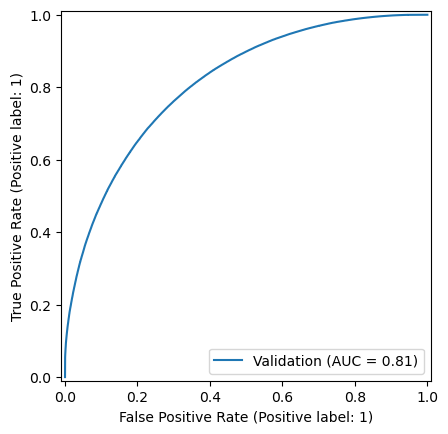

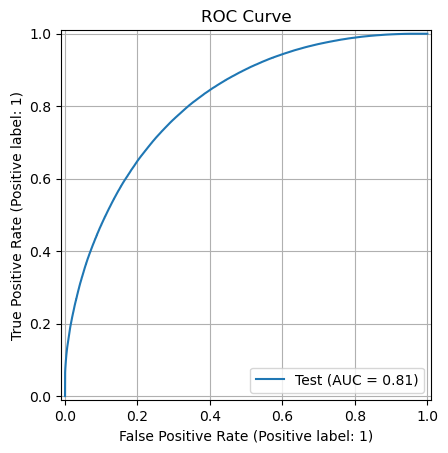

In [28]:
# ROC curve (Validation vs Test)
plt.figure(figsize=(7, 5))
RocCurveDisplay.from_predictions(y_val, val_proba, name="Validation")
RocCurveDisplay.from_predictions(y_test, test_proba, name="Test")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


<Figure size 700x500 with 0 Axes>

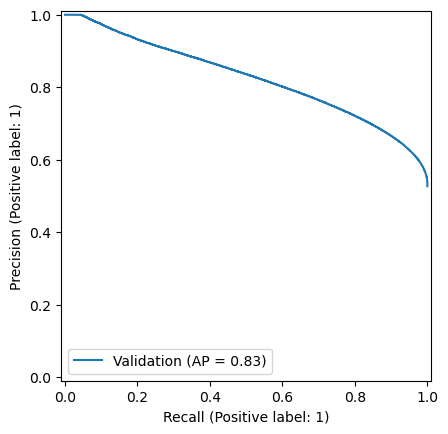

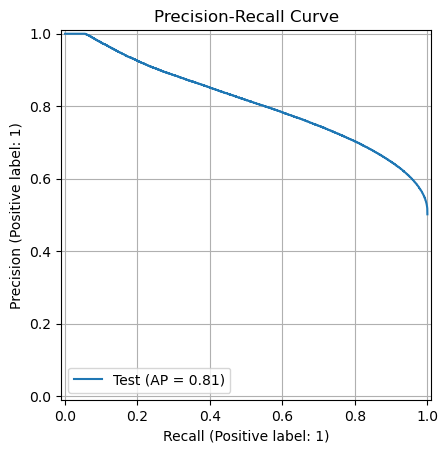

In [29]:
# Precision-Recall curve (Validation vs Test)
plt.figure(figsize=(7, 5))
PrecisionRecallDisplay.from_predictions(y_val, val_proba, name="Validation")
PrecisionRecallDisplay.from_predictions(y_test, test_proba, name="Test")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [30]:
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
importances

user_like_rate        0.316964
movie_mean_rating     0.194618
movie_like_rate       0.182164
user_mean_rating      0.029418
gen_pca_0             0.019885
                        ...   
Film-Noir             0.001697
Mystery               0.001614
War                   0.001584
Action                0.001317
(no genres listed)    0.000000
Length: 77, dtype: float32

## Quick Conclusions:

- PCA did not make significant changes in the final metrics
- Nevertheless, some of this features could make it to the top 10 of importance.
- We need to prune and make some selection, at this point the new features add noise.  